# Devils DFTD 2-Stage Infection

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import time
import json
import pickle

In [3]:
from gillespy2 import TauHybridCSolver, cleanup_tempfiles

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)

## With Vaccination + Culling Interventions
### Load existing state

In [7]:
vccl_state_path = "ParameterSweeps/DevilsDFTD2StageInfectionWithVaccinationAndCullingState.p"
if os.path.exists(vccl_state_path):
    with open(vccl_state_path, "rb") as vccl_state_file:
        vccl_state = pickle.load(vccl_state_file)
        
    # Model
    vccl_model = vccl_state['model']
    # Simulation
    vccl_sim = Simulation.load_state(vccl_state['sim'])
    # Parameter Sweep Job
    vccl_job = ParameterSweep.load_state(vccl_state['job'], batch_size=150, statefile=vccl_state_path)
else:
    vccl_state = None
    print("No existing vaccination + culling state found.")

    # Model
    vccl_model = DevilsDFTD2StageInfection(devil_pop, interventions=["vaccination", "culling"])
    # Simulation
    vccl_sim = Simulation(model=vccl_model)
    # Parameter Sweep Job
    vccl_job = ParameterSweep(model=vccl_model, batch_size=150, statefile=vccl_state_path)

### Solver

In [8]:
vccl_sol = delayed(TauHybridCSolver)(model=vccl_model, variable=True, delete_directory=False)

### Simulation

In [9]:
vccl_sim.configure(solver=vccl_sol)
%time _ = vccl_sim.run(use_existing_results=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [10]:
vccl_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 0%
Devil extinction: 0%


### Visualize Simulation Results

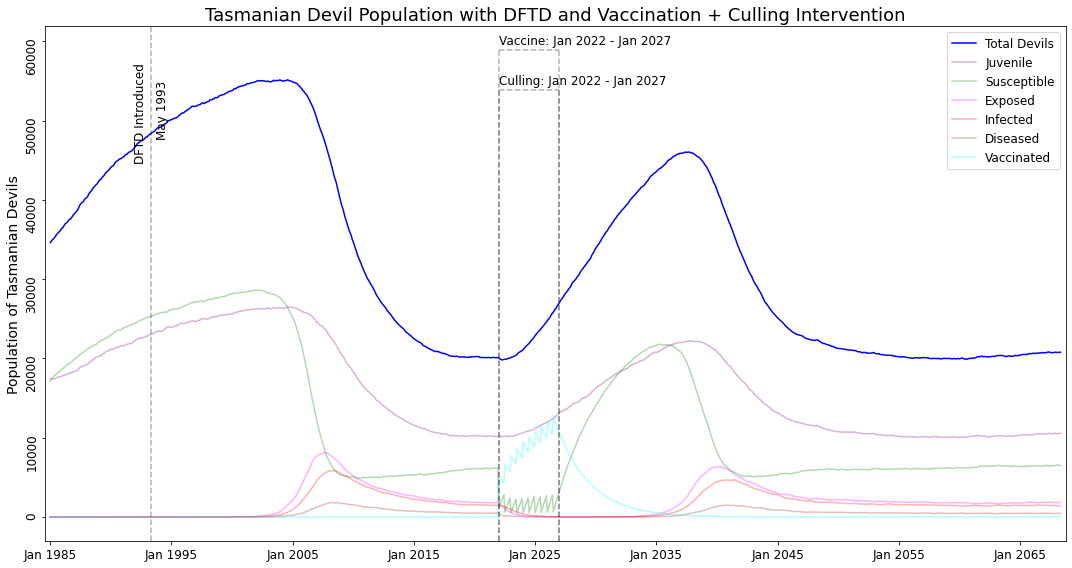

In [11]:
vccl_sim.plot()

### Parameter Sweep

In [12]:
params = [
    {"parameter": "vaccinated_infection_rate", "range": [0.1, 0.2, 0.4, 0.6]},
    {"parameter": "vaccination_proportion", "range": [0.6, 0.8, 1.0]},
    {"parameter": "vacc_program_length", "range": [3, 5, 6, 7, 8, 9, 10, 11]},
    {"parameter": "vaccine_frequency", "range": [2, 4, 6]},
    {"parameter": "cull_rate_diseased", "range": [0.25, 0.5, 0.75]},
    {"parameter": "cull_program_length", "range": [3, 5, 6, 7, 8, 9, 10, 11]}
]

In [13]:
new_params = vccl_job.params != params
%time vccl_job.run(solver=vccl_sol, params=params)

Running 0 new parameter points in 0 batches with 150 points per batch
CPU times: user 76.3 ms, sys: 13 ms, total: 89.3 ms
Wall time: 17.3 ms


### Visualize Parameter Sweep Results

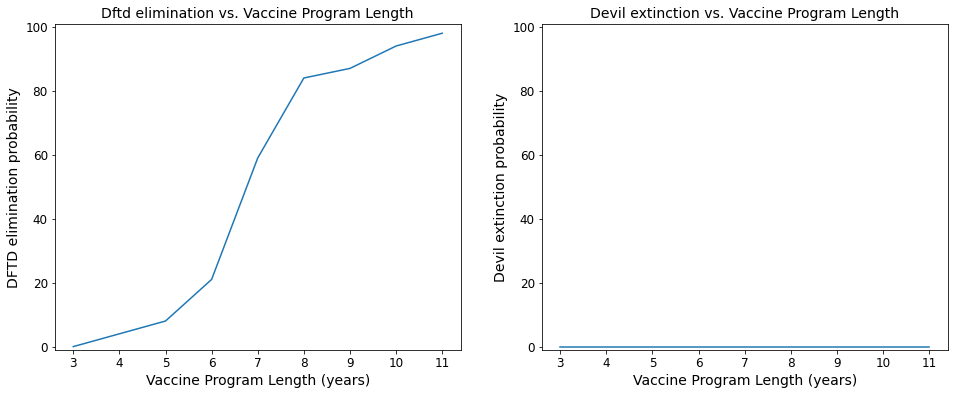

In [14]:
res_sub_keys=["vaccine_frequency:6", "vaccination_proportion:0.8", "vaccinated_infection_rate:0.6",
              "cull_rate_diseased:0.5", "cull_program_length:5"]
vccl_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="vacc_program_length", param_label="Vaccine Program Length", units="years"
)

In [15]:
vccl_job.explore_results()

Output()

### Store Vaccination + Culling State

In [16]:
vccl_state = {"model": vccl_model, "sim":vccl_sim, "job":vccl_job}
with open(vccl_state_path, "wb") as vccl_state_file:
    pickle.dump(vccl_state, vccl_state_file)

## Clean Up Solver Files

In [17]:
cleanup_tempfiles()

In [18]:
c.close() # close the dask client